In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import warnings
warnings.filterwarnings("ignore")

## Uploading NYC Listings Data

In [5]:
data = pd.read_csv("listings.csv")
data.head(3)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2595,https://www.airbnb.com/rooms/2595,2.020100e+13,10/7/20,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...",Centrally located in the heart of Manhattan ju...,https://a0.muscache.com/pictures/f0813a11-40b2...,2845,https://www.airbnb.com/users/show/2845,Jennifer,9/9/08,"New York, New York, United States",A New Yorker since 2000! My passion is creatin...,within a day,70%,25%,f,https://a0.muscache.com/im/pictures/user/50fc5...,https://a0.muscache.com/im/pictures/user/50fc5...,Midtown,6.0,6.0,"['email', 'phone', 'reviews', 'offline_governm...",t,t,"New York, United States",Midtown,Manhattan,40.75362,-73.98377,Entire apartment,Entire home/apt,2,NaN,1 bath,NaN,1.0,"[""Hot water"", ""Stove"", ""Extra pillows and blan...",$175.00,3,1125,3.0,3.0,1125.0,1125.0,3.0,1125.0,NaN,t,30,60,90,365,10/7/20,48,1,0,11/21/09,11/4/19,94.0,9.0,9.0,10.0,10.0,10.0,9.0,NaN,f,2,2,0,0,0.36
1,3831,https://www.airbnb.com/rooms/3831,2.020100e+13,10/9/20,"Whole flr w/private bdrm, bath & kitchen(pls r...","Enjoy 500 s.f. top floor in 1899 brownstone, w...",Just the right mix of urban center and local n...,https://a0.muscache.com/pictures/e49999c2-9fd5...,4869,https://www.airbnb.com/users/show/4869,LisaRoxanne,12/7/08,"New York, New York, United States",Laid-back Native New Yorker (formerly bi-coast...,within an hour,98%,96%,f,https://a0.muscache.com/im/users/4869/profile_...,https://a0.muscache.com/im/users/4869/profile_...,Clinton Hill,1.0,1.0,"['email', 'phone', 'reviews', 'offline_governm...",t,t,"Brooklyn, New York, United States",Clinton Hill,Brooklyn,40.68514,-73.95976,Entire guest suite,Entire home/apt,3,NaN,1 bath,1.0,3.0,"[""Hot water"", ""Stove"", ""Free parking on premis...",$76.00,1,730,1.0,2.0,1125.0,1125.0,1.0,1125.0,NaN,t,2,2,2,2,10/9/20,354,70,3,9/30/14,9/20/20,89.0,8.0,9.0,9.0,9.0,9.0,9.0,NaN,f,1,1,0,0,4.82
2,5121,https://www.airbnb.com/rooms/5121,2.020100e+13,10/9/20,BlissArtsSpace!,<b>The space</b><br />HELLO EVERYONE AND THANK...,NaN,https://a0.muscache.com/pictures/2090980c-b68e...,7356,https://www.airbnb.com/users/show/7356,Garon,2/3/09,"New York, New York, United States","I am an artist(painter, filmmaker) and curato...",NaN,NaN,100%,f,https://a0.muscache.com/im/pictures/user/72a61...,https://a0.muscache.com/im/pictures/user/72a61...,Bedford-Stuyvesant,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'off...",t,t,NaN,Bedford-Stuyvesant,Brooklyn,40.68688,-73.95596,Private room in apartment,Private room,2,NaN,NaN,1.0,1.0,"[""Wifi"", ""Air conditioning"", ""Heating"", ""Kitch...",$60.00,29,730,29.0,29.0,730.0,730.0,29.0,730.0,NaN,t,2,2,2,2,10/9/20,50,1,0,5/28/09,12/2/19,90.0,8.0,8.0,10.0,10.0,9.0,9.0,NaN,f,1,0,1,0,0.36

## Data Cleaning

Number of missing values in each column

In [6]:
#Number of missing values in each column
for col in data.columns:
    print(col + ', Missing vals:', len(data[col][data[col].isnull()]))

id, Missing vals: 0
listing_url, Missing vals: 0
scrape_id, Missing vals: 0
last_scraped, Missing vals: 0
name, Missing vals: 16
description, Missing vals: 1281
neighborhood_overview, Missing vals: 16459
picture_url, Missing vals: 0
host_id, Missing vals: 0
host_url, Missing vals: 0
host_name, Missing vals: 17
host_since, Missing vals: 17
host_location, Missing vals: 142
host_about, Missing vals: 17874
host_response_time, Missing vals: 23079
host_response_rate, Missing vals: 23079
host_acceptance_rate, Missing vals: 16865
host_is_superhost, Missing vals: 17
host_thumbnail_url, Missing vals: 17
host_picture_url, Missing vals: 17
host_neighbourhood, Missing vals: 7280
host_listings_count, Missing vals: 17
host_total_listings_count, Missing vals: 17
host_verifications, Missing vals: 0
host_has_profile_pic, Missing vals: 17
host_identity_verified, Missing vals: 17
neighbourhood, Missing vals: 16458
neighbourhood_cleansed, Missing vals: 0
neighbourhood_group_cleansed, Missing vals: 0
latitu

#### Droping columns for selective analysis:

In [7]:
drop_cols = ['listing_url', 'scrape_id', 'last_scraped','neighborhood_overview','neighbourhood','neighbourhood_cleansed','picture_url', 'host_url','host_name','host_about','host_location','host_location',
             'host_thumbnail_url','host_response_time','host_listings_count','host_picture_url','host_neighbourhood','minimum_minimum_nights',
             'maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm','calendar_last_scraped','calendar_updated',
             'first_review','last_review','license','calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms',
             'has_availability','host_acceptance_rate','number_of_reviews_ltm','number_of_reviews_l30d','calculated_host_listings_count','property_type']
df = data.drop(drop_cols, axis=1)
df.columns

Index(['id', 'name', 'description', 'host_id', 'host_since',
       'host_response_rate', 'host_is_superhost', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_group_cleansed', 'latitude', 'longitude', 'room_type',
       'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds',
       'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'reviews_per_month'],
      dtype='object')

#### Dropping null rows:
The following columns only have 17 nulls, so we will be dropping the null rows of the columns. We are dropping the null rows instead of entire columns because they are features of interest

In [8]:
#Dropping null rows
df.dropna(subset=['host_since','host_total_listings_count','host_is_superhost','host_has_profile_pic','host_identity_verified','name'], inplace=True)
 

#### Missing Data:

Airbnb Listing Description

In [9]:
#Replacing null listing descriptions with empty string

df['description']=df['description'].replace(np.nan, '')

###### Beds


In [10]:
#Replacing nulls in 'beds' by filling with median value

df['beds'].fillna(df['beds'].median(), inplace=True)

###### Bedrooms

In [11]:
#Replacing nulls in 'bedrooms' by filling with median value

df['bedrooms'].fillna(df['bedrooms'].median(), inplace=True)

#### Data Transformation:

Host is superhost, host has profile_pic, host identity verified, instant bookable

In [12]:
#Replacing host is superhost, host has profile_pic, host identity verified, instant bookable columns (boolean columns) with 0 and 1

df.replace({'f': 0, 't': 1}, inplace=True)

###### Host Since

In [13]:
#Reformatting 'host_since' date

df.host_since = pd.to_datetime(df['host_since'])

###### Price

In [14]:
#Reformat 'price' into integer type (removing $ and converting column into int type)

df['price'] = df['price'].str.replace('[\$\,]|\.\d*', '').astype(int)

###### Bathrooms

In [15]:
#Reformat 'bathrooms' using 'bathrooms_text' to represent number of bathrooms as float instead of string

df['bathrooms'] = df['bathrooms_text'].str.extract(r'(\d*\.?\d+)?').astype('float')

#Replace nulls with median number of bathrooms

df['bathrooms'].fillna(df['bathrooms'].median(), inplace=True)

#Drop 'bathrooms_text' column

df.drop(['bathrooms_text'], axis=1,inplace=True)

###### Host response rate

In [16]:
#Reformat respose rate into proportion represented by decimal 
df['host_response_rate'] = df['host_response_rate'].str.replace(r'%', r'.0').astype('float') / 100.0

#Group host response rates into bins
df["host_response_rate"]=pd.cut(df["host_response_rate"],bins=[0, .25, .50, .75, .99,1],labels=['0-25%', '26-50%','51-75%', '76-99%', '100%'])
df.replace({'0-25%': 1, '26-50%': 2,'51-75%':3,'76-99%':4,'100%':5},inplace=True)

#Replace nulls with median bin value
df['host_response_rate']=df['host_response_rate'].replace(np.nan, 5)

#### Feature Creation:

###### Days of being host

In [17]:
#Length of time the individual has been a host
df['days_of_being_host'] = (pd.datetime(2020, 11, 22) - df['host_since']).astype('timedelta64[D]')

#Replace nulls in 'days_of_being_host' column with median value
df['days_of_being_host'].fillna(df['days_of_being_host'].median(), inplace=True)

##### Length of amenities list

In [18]:
#Creating column for length of amenitites list
df['length_of_amenities_list'] = df['amenities'].str.len()

##### Length of listing description

In [19]:
#Creating column for length of description
df['length_of_description'] = df['description'].str.len()

##### Numeric column for Neighborhood Groups

In [20]:
#Creating column to numerically represent each neighbourhood
df['neighbourhood_group_numeric'] = df['neighbourhood_group_cleansed'].map({'Manhattan':5,'Brooklyn':4,'Queens':3,'Staten Island':2,'Bronx':1}).astype('int')


### Data Visualization and Analysis:

In [21]:
print("Average price of Airbnb listing in NYC: " + "$" + str(np.mean(df['price'])))
print("Lowest price of Airbnb listing in NYC: " + "$" + str(min(df['price'])))
print("Highest price of Airbnb listing in NYC: " + "$" + str(max(df['price'])))

Average price of Airbnb listing in NYC: $150.0939887527166
Lowest price of Airbnb listing in NYC: $0
Highest price of Airbnb listing in NYC: $10000


In [22]:
print("Average accomodated persons: " + str(np.mean(df['accommodates'])))
print("Average host response rate: " + str(np.mean(df['host_response_rate'])))

Average accomodated persons: 2.758273026684292
Average host response rate: 4.744247529854592


In [23]:
#Top 20 most expensive NYC listings
top_20 = df.sort_values('price',ascending=False).head(20)
top_20

,id,name,description,host_id,host_since,host_response_rate,host_is_superhost,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,latitude,longitude,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,days_of_being_host,length_of_amenities_list,length_of_description,neighbourhood_group_numeric
22602,22436899,1-BR Lincoln Center,"One bedroom, great neighborhood, steps away fr...",72390391,2016-05-16,5.0,0,1.0,['phone'],1,0,Manhattan,40.77213,-73.98665,Entire home/apt,4,1.0,1.0,1.0,"[""Wifi"", ""Dryer"", ""Hangers"", ""Smoke alarm"", ""C...",10000,30,120,23,53,83,83,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,1651.0,151,79,5
14181,13925864,Puerto Plata,Puerto Plata<br /><br /><b>The space</b><br />...,58480311,2016-02-12,5.0,0,1.0,"['email', 'phone', 'reviews', 'jumio', 'selfie...",1,1,Queens,40.76168,-73.92986,Entire home/apt,4,1.0,2.0,2.0,"[""TV"", ""Shampoo"", ""Heating"", ""Essentials"", ""Ki...",10000,2,1125,0,0,0,0,28,83.0,9.0,8.0,9.0,9.0,9.0,9.0,0,0.55,1745.0,178,115,3
23062,22985168,Delightful condo,Located on a quite street in Astoria Queens. C...,71733378,2016-05-12,5.0,0,1.0,"['email', 'phone']",1,0,Queens,40.76475,-73.92890,Entire home/apt,2,1.0,1.0,1.0,"[""Wifi"", ""Hangers"", ""Air conditioning"", ""Kitch...",10000,72,1125,1,1,1,1,26,96.0,9.0,9.0,10.0,10.0,9.0,9.0,0,0.79,1655.0,163,352,3
36033,39100961,"Chambers Hotel, Chambers Hotel Queen - ADA",With its art-laden lobby and rooms (over 500 w...,220229838,2018-10-12,2.0,0,11.0,"['email', 'phone']",1,1,Manhattan,40.76225,-73.97463,Private room,2,1.0,1.0,0.0,"[""Wifi"", ""Hangers"", ""Air conditioning"", ""Priva...",10000,1,1125,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,772.0,250,1000,5
29514,31219800,~New jersey loft,"Times Square, Central Park, Flatiron, and so m...",172226912,2018-02-07,5.0,0,1.0,"['email', 'phone']",1,0,Manhattan,40.75020,-73.97905,Shared room,1,2.0,1.0,5.0,"[""Hot water"", ""Fireplace guards"", ""Stove"", ""Ex...",10000,40,365,30,60,90,180,11,90.0,9.0,8.0,9.0,9.0,9.0,8.0,0,0.59,1019.0,699,241,5
36635,39574087,"The Allen Hotel, Deluxe Penthouse King Suite","New on the scene, The Allen blends just the ri...",266741420,2019-06-06,3.0,0,4.0,"['email', 'phone', 'work_email']",1,1,Manhattan,40.71894,-73.99178,Private room,2,1.0,1.0,1.0,"[""Wifi"", ""Air conditioning"", ""Private entrance...",10000,1,1125,30,60,90,365,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,535.0,201,1000,5
14137,13894339,Luxury 1 bedroom apt. -stunning Manhattan views,Our luxury 1 bedroom comfortably fits 3 guests...,5143901,2013-02-19,5.0,0,1.0,"['email', 'phone', 'facebook', 'reviews', 'kba...",1,1,Brooklyn,40.73260,-73.95739,Entire home/apt,3,1.0,1.0,2.0,"[""Laptop-friendly workspace"", ""Pool"", ""Essenti...",10000,5,14,0,0,0,0,5,92.0,10.0,9.0,10.0,10.0,9.0,10.0,0,0.11,2833.0,227,1000,4
26714,28132057,Penthouse Suite at AKA Tribeca,"<b>The space</b><br />- 1,065 square feet<br /...",212484716,2018-08-29,5.0,0,7.0,"['email', 'phone']",1,1,Manhattan,40.75718,-73.96484,Private room,3,1.5,1.0,1.0,"[""Laptop-friendly workspace"", ""Cable TV"", ""Ess...",9999,1,28,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,816.0,156,957,5
26719,28132314,Superior King,<b>The space</b><br />- 425 square feet<br />-...,212484716,2018-08-29,5.0,0,7.0,"['email', 'phone']",1,1,Manhattan,40.75907,-73.96498,Private room,2,1.0,1.0,1.0,"[""Cable TV"", ""Essentials"", ""Heating"", ""Air con...",9999,1,28,0,0,0,0,1,100.0,10.0,10.0,10.0,10.0,10.0,8.0,1,0.04,816.0,127,403,5
26718,28132293,Standard Queen at AKA Tribeca,<b>The space</b><br />- 250 square feet<br />-...,212484716,2018-08-29,5.0,0,7.0,"['email', 'phone']",1,1,Manhattan,40.75866,-73.9

#### Correlation:

In [24]:
corr = df.corr()
corr = (corr)
corr['review_scores_rating'].sort_values(ascending=False)


review_scores_rating           1.000000
review_scores_value            0.781324
review_scores_accuracy         0.778283
review_scores_cleanliness      0.738373
review_scores_communication    0.698673
review_scores_checkin          0.646595
review_scores_location         0.515792
host_is_superhost              0.189437
length_of_amenities_list       0.131850
days_of_being_host             0.110850
length_of_description          0.082990
host_response_rate             0.073897
number_of_reviews              0.050185
reviews_per_month              0.045972
host_has_profile_pic           0.016606
bedrooms                       0.015657
price                          0.011306
host_identity_verified         0.010765
accommodates                  -0.000262
beds                          -0.006482
minimum_nights                -0.012296
maximum_nights                -0.012374
longitude                     -0.019376
neighbourhood_group_numeric   -0.020981
host_total_listings_count     -0.023072


###### Observations
Top 2 features that correlate with review scores rating (including other review score categories): review scores value (score on booking's monetary value) & review scores accuracy (score on accuracy of property's description)

Top 3 features that correlate with review scores rating (excluding other review score categories): host is superhost, length of amenities list, & days of being host


###### Takeaways

Because a host's overall review rating has the highest correlation with review scores value, this possibly indicates that for hosts to receive a higher overall review scores rating, the value of their Airbnb listing has to be high. 
Since review scores accuracy had the second highest correlation with review scores rating, this could also indicate that in order for hosts to receive a higher review score, they should have very accurate property descriptions.

The correlation between review scores rating and whether a host is a superhost may indicate that superhosts receive higher review scores than hosts who are not a superhost.

The correlation between review scores rating and the length of the amenities list might mean that hosts are more likely to get high review scores if they offer more amenities.

The correlation between review scores rating and number of days a person has been a host could also be indicative of the notion that the longer a person is a host, the more likely they are to receive a higher rated review. 

Text(0.5, 1.0, 'Pair-wise correlation')

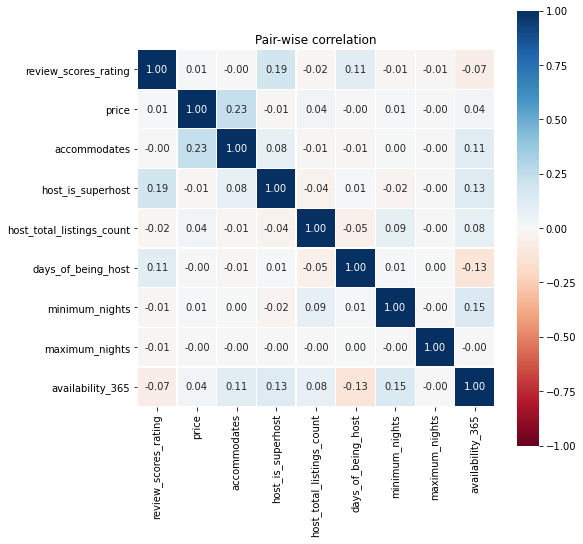

In [25]:
corr_cols = ['review_scores_rating', 'price', 'accommodates','host_is_superhost','host_total_listings_count','days_of_being_host','minimum_nights','maximum_nights','availability_365']
colormap = plt.cm.RdBu
plt.figure(figsize=(8,8))
sns.heatmap(df[corr_cols].astype(float).corr(), linewidths=0.1, vmax=1.0, vmin=-1., square=True, cmap=colormap, linecolor='white', annot=True,fmt=".2f")
plt.title('Pair-wise correlation')

###### Observations
The overall review scores rating is most correlated with whether a host is a superhost and the days the person has been a host. We can also see that price is most correlated with the number of people that can be accomodated and the listing's neighbourhood.

###### Takeaways
We can again infer that hosts will receive higher overall review scores if they are a superhost and if they have been a host for a long time. 

Because price is most correlated with number of people accomodated and neighborhood, hosts should consider the two factors in order to have a more successful listing.

## Plots

##### Visualizing Top 20 Most Expensive Listings

Text(0.5, 0, 'neighborhood')

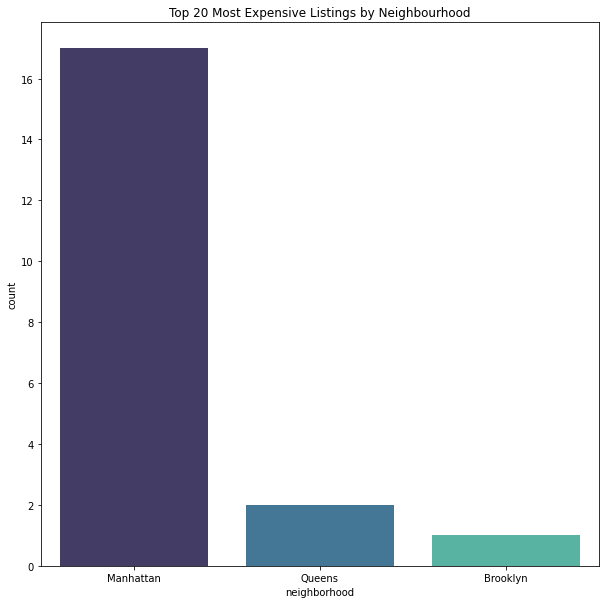

In [26]:
sns.countplot(top_20['neighbourhood_group_cleansed'], palette="mako")
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.title('Top 20 Most Expensive Listings by Neighbourhood')
plt.xlabel('neighborhood')

In [27]:
top_20[['host_response_rate','neighbourhood_group_cleansed','accommodates','review_scores_rating','host_is_superhost','room_type']].mode()

,host_response_rate,neighbourhood_group_cleansed,accommodates,review_scores_rating,host_is_superhost,room_type
0,5.0,Manhattan,2,100.0,0,Private room


From the barplot and our query above, we can see that of the top 20 most expensive listings, the majority are located in Manhattan. Our query also shows that majority of the top 20 listings are of hosts with the following: a response rate in bin 5 (100% response rate), listings that accommodate 2 guests, review scores rating of 100, not superhosts, and listings of private rooms.
It is interesting to note that even though we found a correlation between a high overall review rating score and whether a host is superhost, the majority of the most expensive listings are of non-superhosts. Therefore, we need to further investigate whether it is important that hosts are superhosts to have higher review scores and have a more successful listing

------


 ##### Visualizing All Listings



Using longitude and latitude to create simple scatter plot of all listing locations


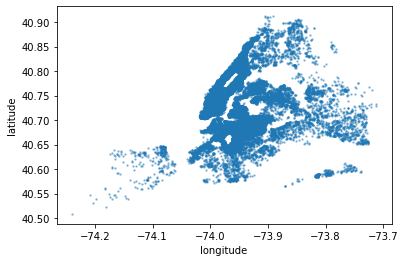

In [28]:
df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,s=2)
plt.show()

-------

Visualizing listings by room type

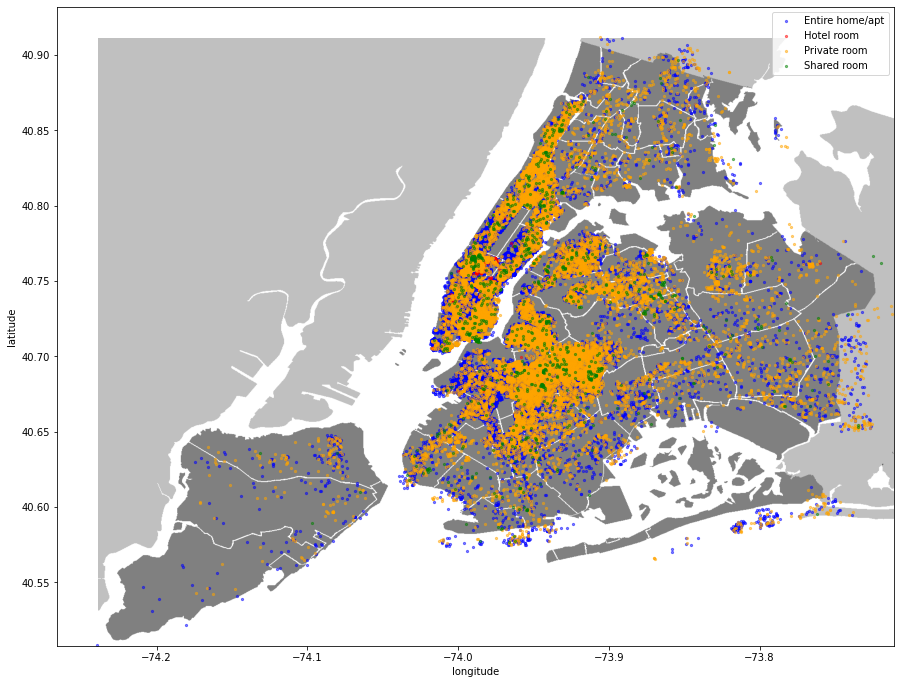

In [31]:
plt.figure(figsize=(15,15))

nyc_img=plt.imread('Neighbourhoods_New_York_City_Map.PNG')
plt.imshow(nyc_img,zorder=0,extent=[-74.239, -73.711, 40.508,40.911])
ax=plt.gca()

colors = {'Entire home/apt':'blue', 'Private room':'orange', 'Shared room':'green', 'Hotel room':'red'}

grouped = df.groupby('room_type')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='longitude', y='latitude', label=key, color=colors[key],s=5,alpha=0.5)

plt.show()

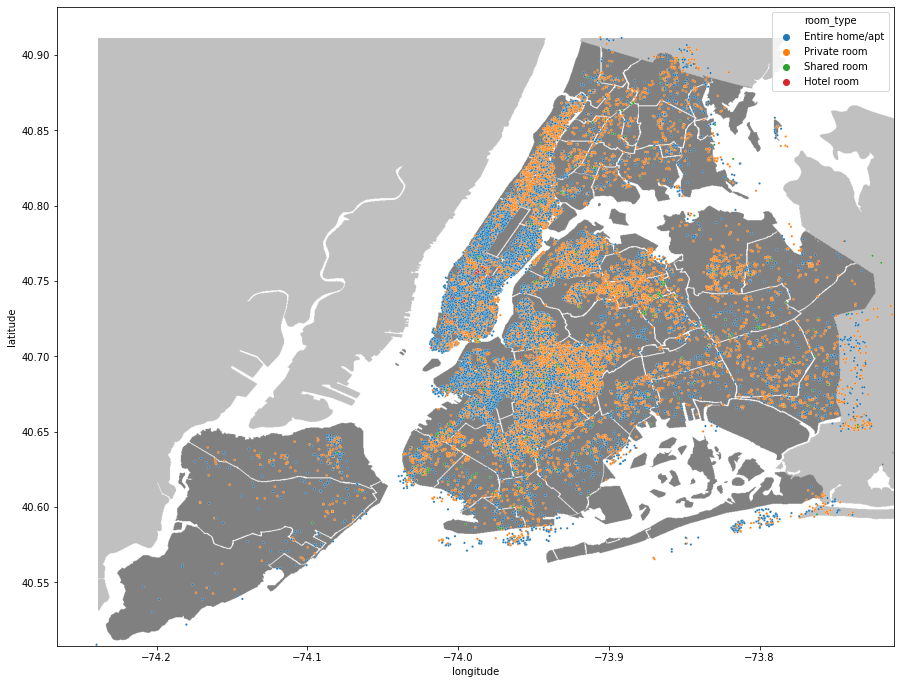

In [32]:
plt.figure(figsize=(15,15))
nyc_img=plt.imread('Neighbourhoods_New_York_City_Map.PNG')
plt.imshow(nyc_img,zorder=0,extent=[-74.239, -73.711, 40.508,40.911])
ax=plt.gca()
sns.scatterplot(df.longitude,df.latitude,hue=df.room_type,s=5)
plt.show()

Text(0.5, 0, 'room type')

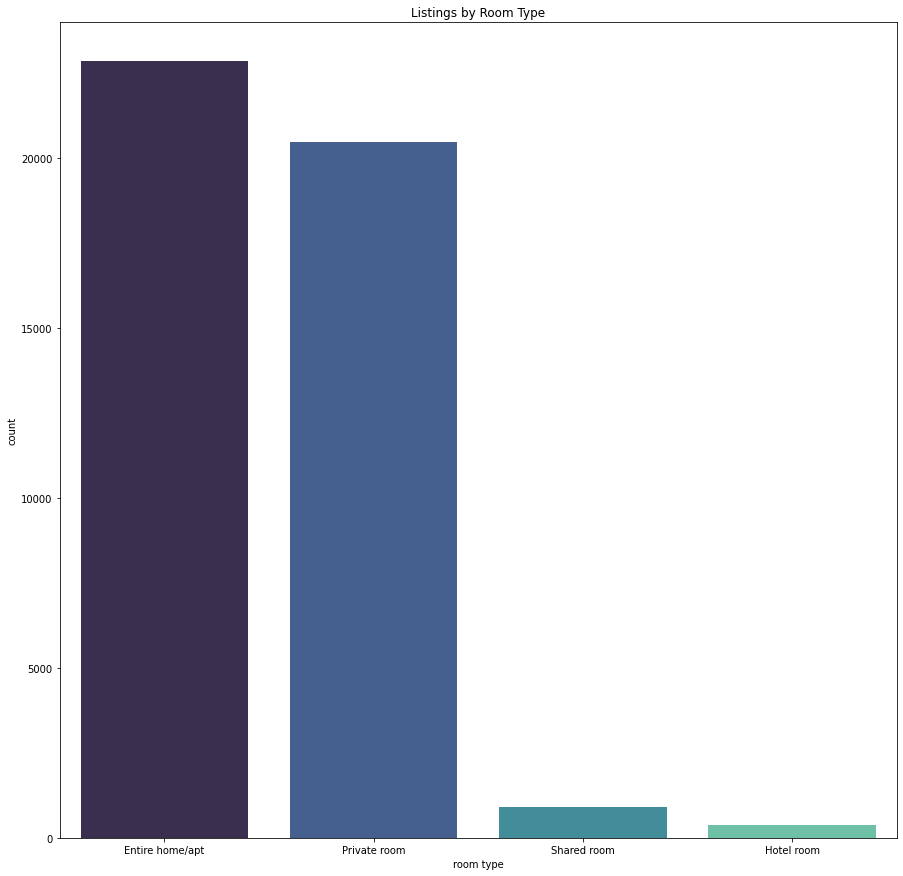

In [33]:
sns.countplot(df['room_type'], palette="mako")
fig = plt.gcf()
fig.set_size_inches(15,15)
plt.title('Listings by Room Type')
plt.xlabel('room type')

Of all listings in NYC, the majority are of the entire home/apt.

-------

Visualizing listings by neighborhood


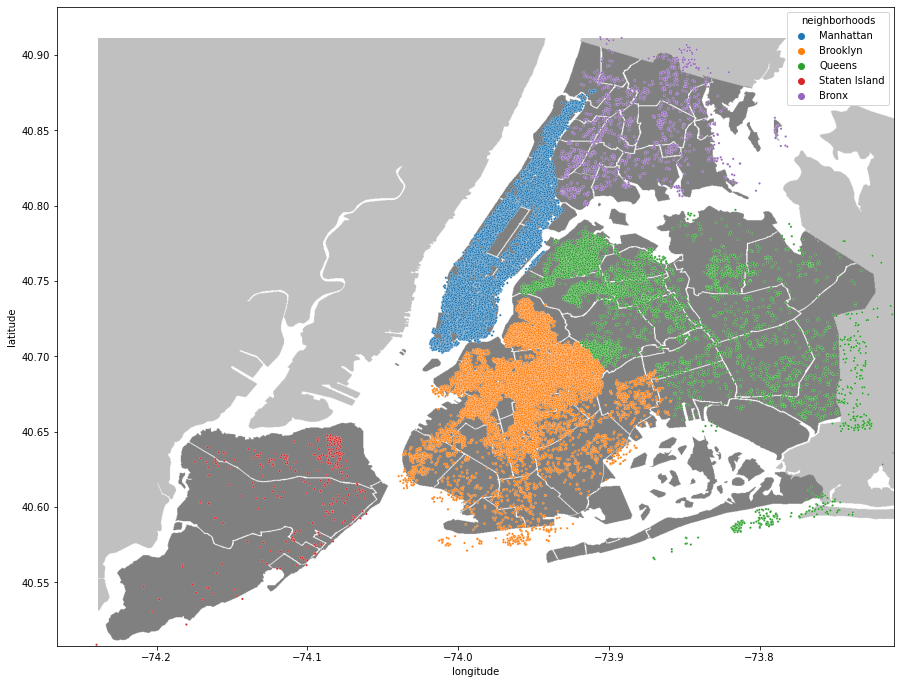

In [35]:
plt.figure(figsize=(15,15))

nyc_img=plt.imread('Neighbourhoods_New_York_City_Map.PNG')

plt.imshow(nyc_img,zorder=0,extent=[-74.239, -73.711, 40.508,40.911])
ax=plt.gca()

sns.scatterplot(df.longitude,df.latitude,hue=df.neighbourhood_group_cleansed,s=5)
plt.legend(title='neighborhoods')
plt.show()

Text(0.5, 0, 'neighborhood')

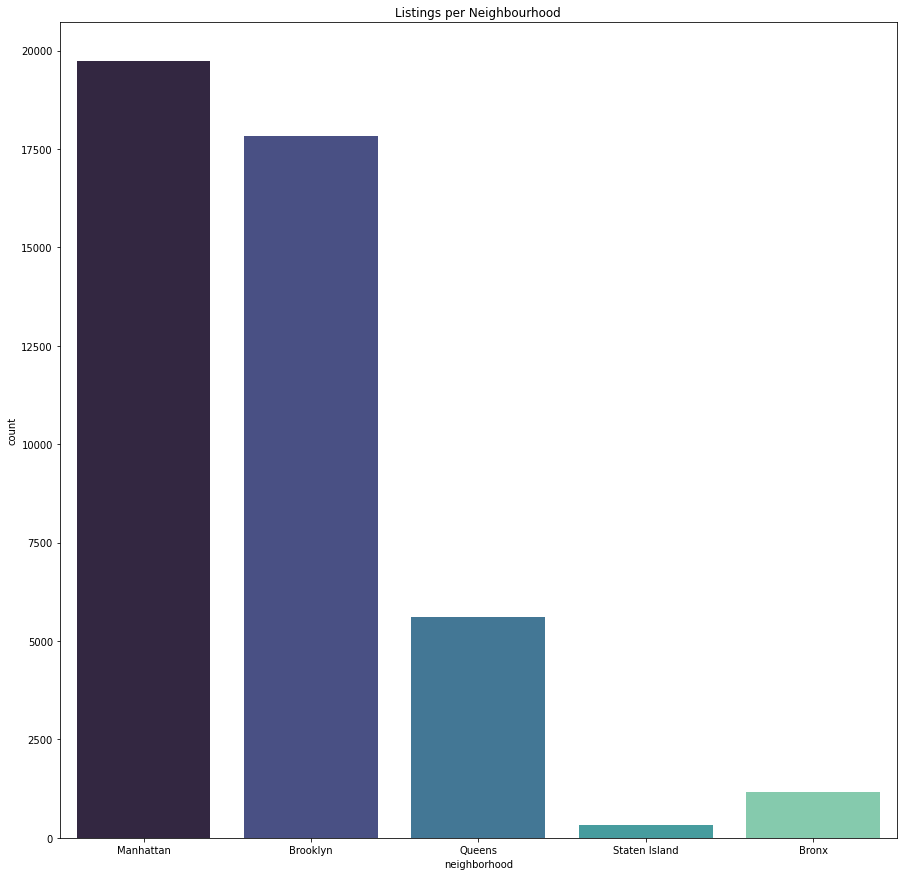

In [36]:
sns.countplot(df['neighbourhood_group_cleansed'], palette="mako")
fig = plt.gcf()
fig.set_size_inches(15,15)
plt.title('Listings per Neighbourhood')
plt.xlabel('neighborhood')

Most listings are in Manhattan.

-----

Visualizing number of listings: neighborhood and room type

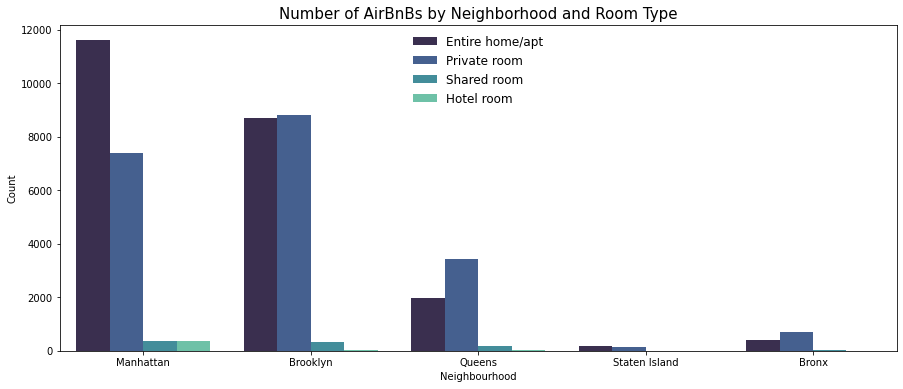

In [37]:
plt.figure(figsize=(15,6))
sns.countplot(data=df, x='neighbourhood_group_cleansed', hue='room_type', palette='mako')
plt.title('Number of AirBnBs by Neighborhood and Room Type', fontsize=15)
plt.xlabel('Neighbourhood')
plt.ylabel("Count")
plt.legend(frameon=False, fontsize=12)

Most listings are for an entire home/apt in Manhattan

------

#### Implementing color scale to visualize listings by price


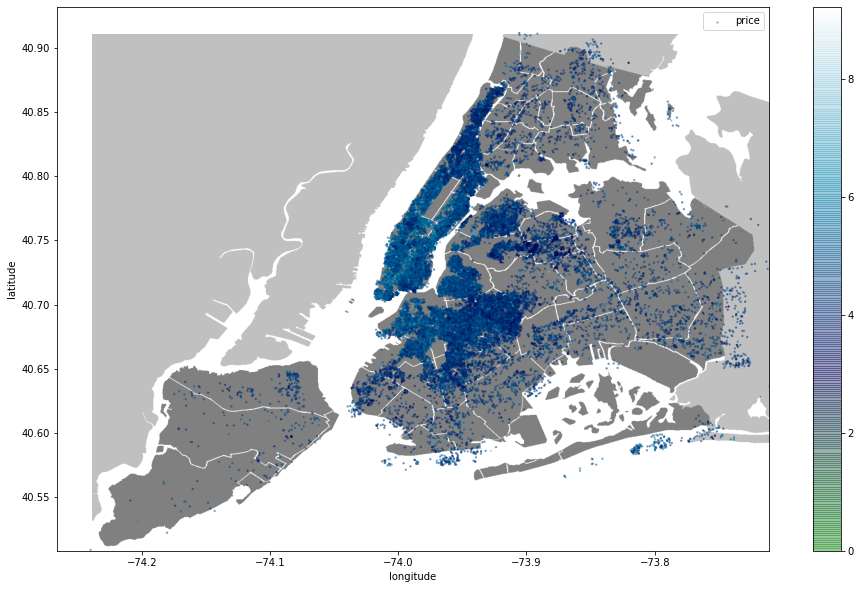

In [38]:
plt.figure(figsize=(16,10))

#i=urllib.request.urlopen('https://upload.wikimedia.org/wikipedia/commons/e/ec/Neighbourhoods_New_York_City_Map.PNG')
nyc_img=plt.imread('Neighbourhoods_New_York_City_Map.PNG')
plt.imshow(nyc_img,zorder=0,extent=[-74.239, -73.711, 40.508,40.911])
ax=plt.gca()

#Using log of price for normalization
log_p = np.log1p(df['price'])

df.plot(kind='scatter', x='longitude', y='latitude', label='price', c=log_p, ax=ax, 
           cmap=plt.get_cmap('ocean'), colorbar=True, alpha=0.4, zorder=5,s=2)

plt.legend()
plt.show()

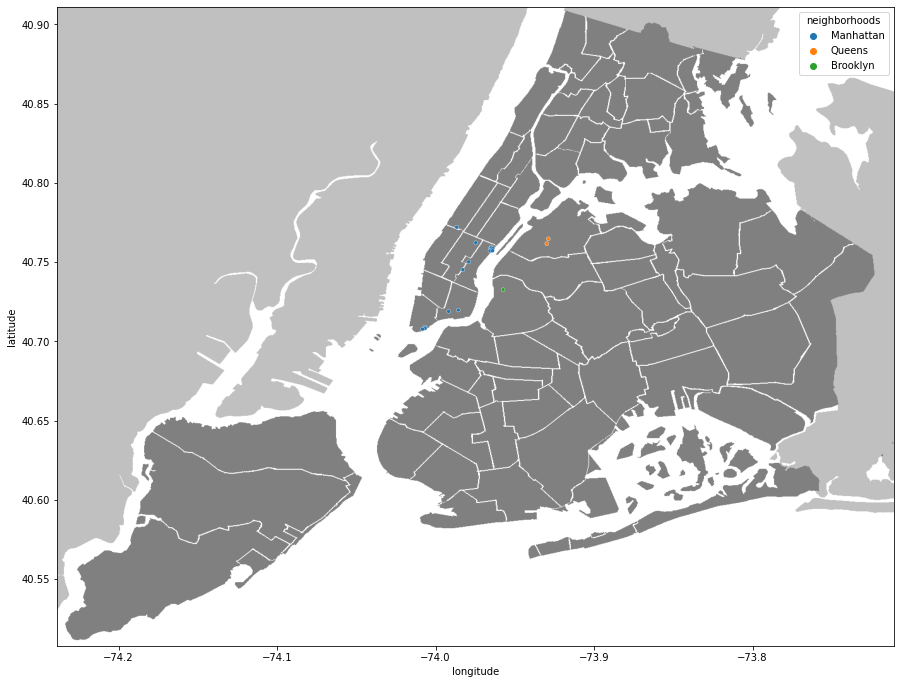

In [39]:
#Using map to visualize top 20 most expensive listings
plt.figure(figsize=(15,15))

nyc_img=plt.imread('Neighbourhoods_New_York_City_Map.PNG')

plt.imshow(nyc_img,zorder=0,extent=[-74.239, -73.711, 40.508,40.911])
ax=plt.gca()

sns.scatterplot(top_20.longitude,top_20.latitude,hue=top_20.neighbourhood_group_cleansed,s=15)
plt.legend(title='neighborhoods')
plt.show()

Most expensive listings concentrated in Manhattan

----

#### Superhost and listing prices

Text(0.5, 1.0, 'Host Type Across Neighborhoods')

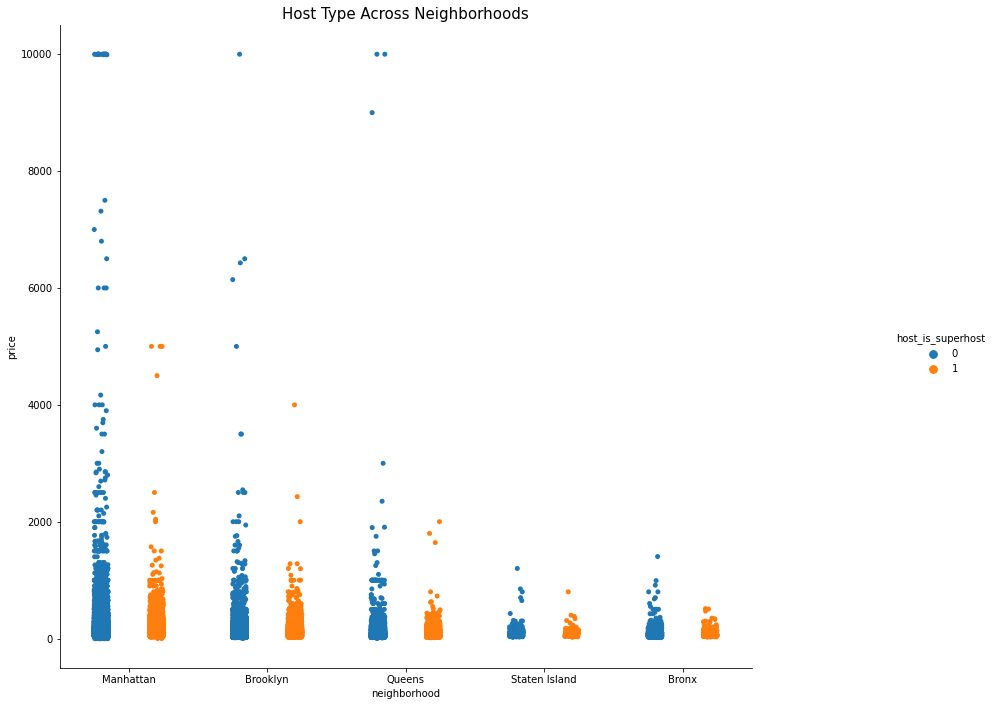

In [40]:
import matplotlib.pyplot as plt
from matplotlib import pyplot

g = sns.catplot(x="neighbourhood_group_cleansed", y="price",hue="host_is_superhost", data=df,s=5,dodge=True)
plt.xlabel('neighborhood')
g.fig.set_figwidth(15)
g.fig.set_figheight(10)
plt.title('Host Type Across Neighborhoods', fontsize=15)

This visual shows that across all neighborhoods, the listings are of non-superhosts. It also appears that superhosts tend to have higher priced listings than non-superhosts for each neighborhood.

Text(0.5, 1.0, 'Host Type Across Room Type')

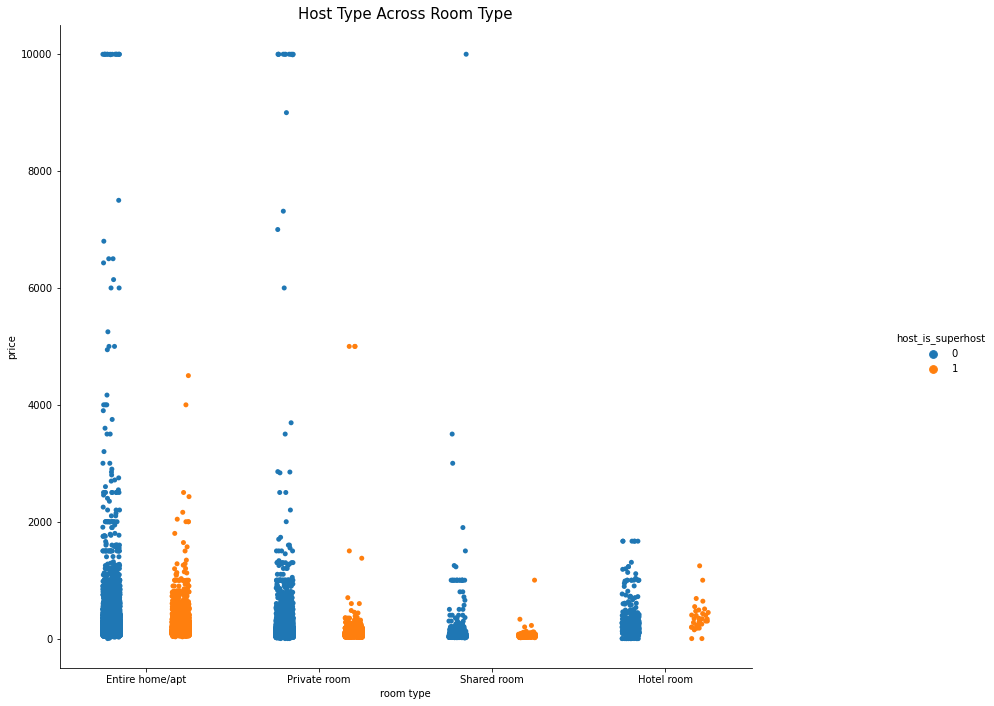

In [41]:
g = sns.catplot(x="room_type", y="price",hue="host_is_superhost", data=df,s=5,dodge=True)
plt.xlabel('room type')
g.fig.set_figwidth(15)
g.fig.set_figheight(10)
plt.title('Host Type Across Room Type', fontsize=15)